<a href="https://colab.research.google.com/github/elliotgunn/DS-Unit-2-Kaggle-Challenge/blob/master/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [x] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [x] Get your validation accuracy score.
- [x] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

In [144]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

## Train/val/test

In [145]:
# split train into: train & val

train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'], random_state=42)

# test has already been assigned a separate csv

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

## Define a function to wrangle train, validate, and test sets in the same way. 
Clean outliers and engineer features. (For example, what other columns have zeros and shouldn't? What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)

In [0]:
import numpy as np

def clean(X):
  
  # make a copy before modifying
  X = X.copy()
  
  # duplicates, near duplicates, missing values
  X = X.drop(columns=['payment', 'quantity_group', 'source_type', 'waterpoint_type', 
         'extraction_type', 'extraction_type_class', 'management_group',
         'water_quality', 'num_private'])
  
  # About 3% of the time, latitude has small values near zero,
  # outside Tanzania, so we'll treat these values like zero.
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  
  # some columns have zeros and shouldn't, they are like null values
  # replace those zeros with nulls, impute missing values later
  cols_with_zeros = ['longitude', 'latitude', 'population', 'construction_year']
  for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)
  
  # extract year from date_recorded
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  X['date_recorded'] = X['date_recorded'].dt.year
  
  # age of pump at time of inspection
  X['pump_age'] = X['date_recorded'] - X['construction_year']
  # there are five values with negatives, so we will return those as a np.nan
  X['pump_age'] = X['pump_age'].replace([-5, -4, -3, -2, -1, -7], np.nan)
  
  # return the clean df
  return X

train = clean(train)
val = clean(val)
test = clean(test)

In [126]:
# check for 0s

test['pump_age'].value_counts(ascending=False)

3.0     629
1.0     577
2.0     571
5.0     500
13.0    423
4.0     412
7.0     394
6.0     345
11.0    319
14.0    293
8.0     268
33.0    247
16.0    235
15.0    230
19.0    200
23.0    199
10.0    188
31.0    185
27.0    183
9.0     183
28.0    181
18.0    181
25.0    161
17.0    160
12.0    147
21.0    144
29.0    142
35.0    140
0.0     139
41.0    133
26.0    131
37.0    128
20.0    124
39.0    121
38.0     90
36.0     85
22.0     77
30.0     70
43.0     69
24.0     61
40.0     57
34.0     49
32.0     40
42.0     22
50.0     21
53.0     20
45.0     14
44.0     11
48.0      7
51.0      7
46.0      7
52.0      5
47.0      4
49.0      2
Name: pump_age, dtype: int64

In [9]:
train.describe(exclude='number')

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,47520,44616,44603,47520,47520,47234,47520,47520,47520,44876,47520,44392,24988,45077,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520,47520
unique,349,1716,1929,30661,9,17231,21,124,2082,2,1,12,2563,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,474,7321,13978,2879,8137,420,4250,2003,257,40838,47520,29470,548,31071,21448,21448,21448,32449,42027,20287,20287,40598,40598,26567,26567,13620,13620,36638,22778,27642,25807


In [23]:
## first make decisions about duplicates

# look at payment & payment_type
# they are duplicates
# drop payment as more wordy

# duplicates: ['quantity', 'quantity_group']

# near duplicates: ['source', 'source_type']: drop source_type, keep source_class 
# as it is differently categorized
# near duplicates: ['waterpoint_type_group', 'waterpoint_type'] 

train[['payment', 'payment_type']].describe()

train[['quantity', 'quantity_group']].describe()

print(train['waterpoint_type'].unique())
print(train['waterpoint_type_group'].unique())

# train[['source', 'source_type']].head()

# kept the middle one

train['extraction_type'].value_counts()
train['extraction_type_group'].value_counts()
train['extraction_type_class'].value_counts()

['communal standpipe' 'hand pump' 'other' 'communal standpipe multiple'
 'improved spring' 'cattle trough' 'dam']
['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam']


In [0]:
# most of the data is missing
train['num_private'].value_counts()

In [142]:
train.describe(exclude='object')

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,pump_age
count,47520.000000,47520.000000,47520.000000,47520.000000,46078.000000,46078.000000,47520.000000,47520.000000,47520.000000,30454.000000,31003.000000,30994.000000
mean,37037.915699,321.925261,2011.921907,669.567656,35.149033,-5.884512,0.477736,15.258291,5.616751,280.566034,1996.825469,15.348906
std,21412.099719,3197.240487,0.959690,693.005745,2.604241,2.805599,13.312977,17.530228,9.621230,553.488321,12.499247,12.521597
min,0.000000,0.000000,2002.000000,-63.000000,29.607122,-11.649440,0.000000,1.000000,0.000000,1.000000,1960.000000,0.000000
25%,18482.750000,0.000000,2011.000000,0.000000,33.284679,-8.633876,0.000000,5.000000,2.000000,40.000000,1988.000000,4.000000
50%,36986.500000,0.000000,2012.000000,372.500000,35.008578,-5.170151,0.000000,12.000000,3.000000,150.000000,2000.000000,13.000000
75%,55450.250000,25.000000,2013.000000,1320.000000,37.223501,-3.375068,0.000000,17.000000,5.000000,321.000000,2008.000000,25.000000
max,74247.000000,350000.000000,2013.000000,2770.000000,40.344301,-0.998464,1776.000000,99.000000,80.000000,15300.000000,2013.000000,53.000000


## Select features. Get your validation accuracy score.
Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [147]:
target = 'status_group'

# drop target and id
train_features = train.drop(columns=[target, 'id'])

## NUMERIC FEATURES
# this pulls the entire df: train_features.select_dtypes(include='number')
# therefore we grab only column names into a list
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

## CATEGORICAL FEATURES
cardinality = train_features.select_dtypes(exclude='number').nunique()
# index before tolist() to grab the names, not cardinality
categorical_features = cardinality[cardinality <= 50].index.tolist()

# all features

features = numeric_features + categorical_features
print(features)




['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'pump_age', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type_group', 'management', 'payment_type', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type_group']


In [0]:
# arrange data into X features matrix and y target vector

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [154]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(),
      StandardScaler(),
      DecisionTreeClassifier(min_samples_leaf=25, random_state=42)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on val
print('Decision Tree:')
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

# the validation accuracy score increased when I reduced the model complexity 


Decision Tree:
Train Accuracy 0.7986531986531986
Validation Accuracy 0.763973063973064


## Get and plot your feature importances.

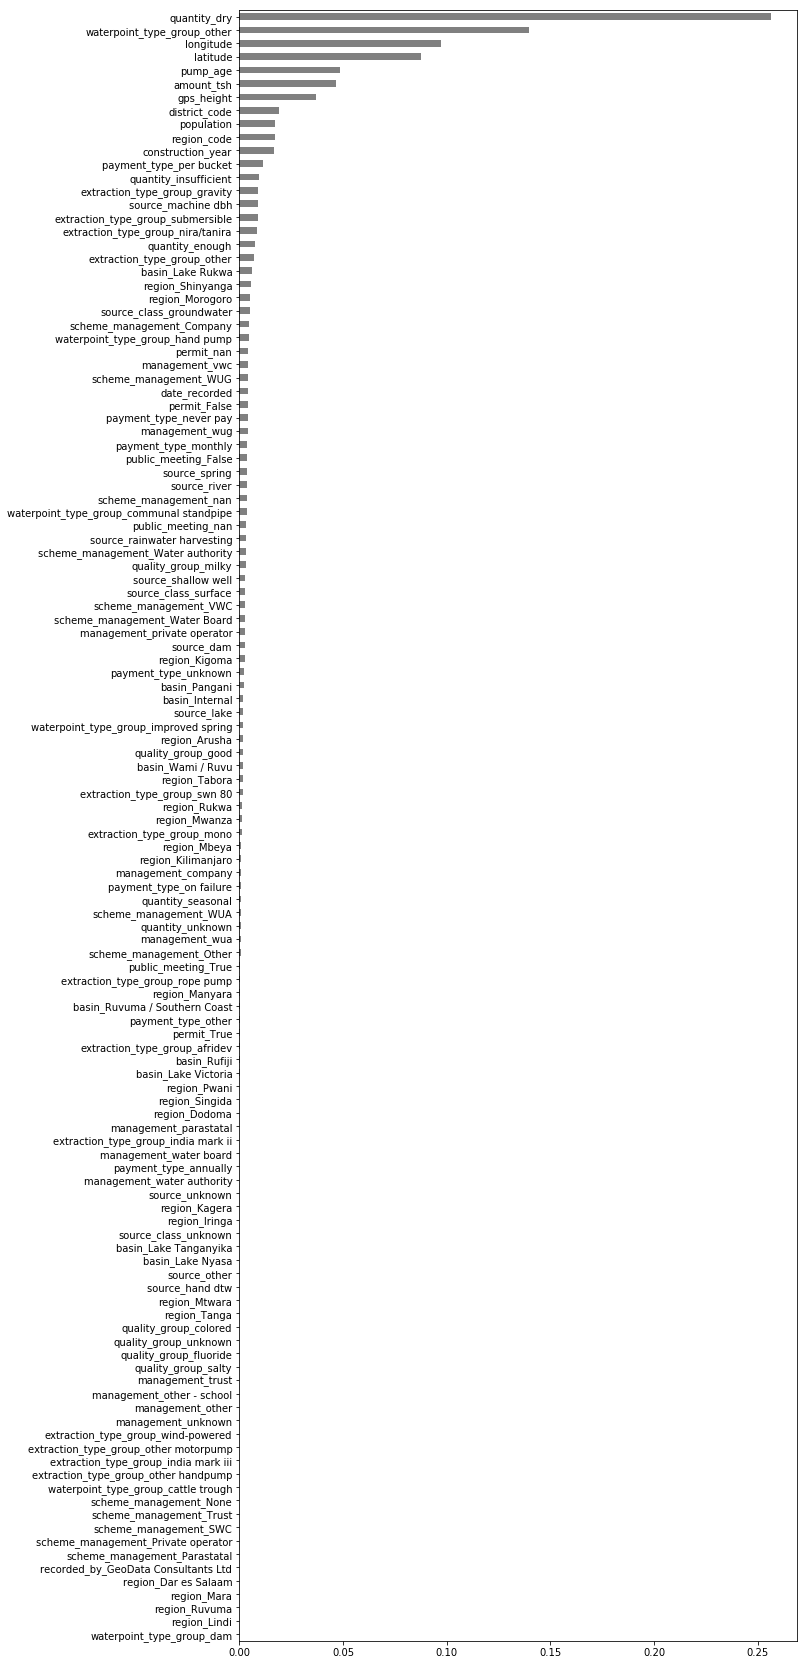

In [159]:
import matplotlib.pyplot as plt

# set model to decision trees
model = pipeline.named_steps['decisiontreeclassifier']


encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');